In [1]:
import numpy as np
import h5py

import MDAnalysis as mda
from MDAnalysis import analysis

import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib inline


In [2]:
import scipy
scipy.__version__

'1.6.3'

In [3]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

#### Import experimental files for 1l2y

In [4]:
filename = "data/20220404_trpcage_reconstructed_saxs.h5"
h5 = h5py.File(filename)
print(h5.keys())

<KeysViewHDF5 ['q_SAD', 's_SAD', 's_SAD_err', 's_int', 's_int_err', 's_unf', 's_unf_err']>


In [5]:
# Set measurement q to experimental q
mea = Measurement(q = np.squeeze(h5['q_SAD'][:]))
print(np.shape(mea.q))

(136,)


In [6]:
# Create Experiment class objects for each species
F_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][0,:]), S_err = np.squeeze(h5['s_SAD_err'][0,:]))
U_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][1,:]), S_err = np.squeeze(h5['s_SAD_err'][1,:]))
I_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_int'][:]), S_err = np.squeeze(h5['s_int_err'][:]))
U_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_unf'][:]), S_err = np.squeeze(h5['s_unf_err'][:]))

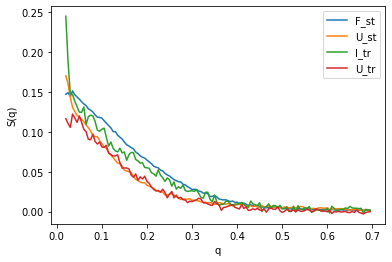

In [7]:
plt.figure()
plt.plot(F_st.q, F_st.S_exp, label="F_st")
plt.plot(U_st.q, U_st.S_exp, label="U_st")
plt.plot(I_tr.q, I_tr.S_exp, label="I_tr")
plt.plot(U_tr.q, U_tr.S_exp, label="U_tr")
plt.xlabel('q')
plt.ylabel('S(q)')
plt.legend()
plt.show()

#### Import the MD trajectory and perform XS calculation on trajectory

In [8]:
# This would be a typical use case

U = mda.Universe("data/1l2y_wb_ions.psf", "data/1l2y_unfold_500K.dcd")

# full trajectory
# traj = traj_slice(U, selection='protein')

# first 100 frames
# traj = Trajectory_slice(U, selection="protein", frame_max = 10)

# This doesn't work yet... OverflowError: Python int too large to convert to C long
# every 50 frames
traj = Trajectory_slice(U, selection="protein", frame_min=0, frame_step=10, ffdir='form_factors/')

print(np.shape(traj.Frames))

env = Environment()

# XS = traj_calc(traj, env, mea)
# print(np.shape(XS))
# Do something with XS. E.g. fitting etc.


There are 12505.0 total frames
Taking the first in every 10.0 frames
(1251,)


#### Compute for every c1 / c2 permutaion the XS_calc of every structure

In [9]:
from itertools import product

In [10]:
c1_grid = np.arange(0.98, 1.051, 0.01)
c2_grid = np.arange(0.0, 4.01, 0.2)
c1c2_product = list(product(c1_grid, c2_grid))
print(len(c1c2_product))

168


In [13]:
# This takes a very long time. Better dump the XS_pool at the end and load when you resume analysis
XS_pool = {}
for c1c2 in c1c2_product:
    print(f'Condition: {c1c2}', end=' ')
    c1, c2 = c1c2
    env = Environment(c1=c1, c2=c2)
    XS_pool[c1c2] = traj_calc(traj, env, mea, method='frame_XS_calc_fast')

Condition: (0.98, 0.0) Done in 31.7662 seconds
Condition: (0.98, 0.2) Done in 50.1928 seconds
Condition: (0.98, 0.4) Done in 51.3514 seconds
Condition: (0.98, 0.6000000000000001) Done in 48.6971 seconds
Condition: (0.98, 0.8) Done in 50.3931 seconds
Condition: (0.98, 1.0) Done in 47.5650 seconds
Condition: (0.98, 1.2000000000000002) Done in 49.8309 seconds
Condition: (0.98, 1.4000000000000001) Done in 51.1556 seconds
Condition: (0.98, 1.6) Done in 52.5224 seconds
Condition: (0.98, 1.8) Done in 53.7357 seconds
Condition: (0.98, 2.0) Done in 56.8775 seconds
Condition: (0.98, 2.2) Done in 50.8638 seconds
Condition: (0.98, 2.4000000000000004) Done in 52.8708 seconds
Condition: (0.98, 2.6) Done in 52.7204 seconds
Condition: (0.98, 2.8000000000000003) Done in 55.6788 seconds
Condition: (0.98, 3.0) Done in 54.5275 seconds
Condition: (0.98, 3.2) Done in 53.9255 seconds
Condition: (0.98, 3.4000000000000004) Done in 45.3115 seconds
Condition: (0.98, 3.6) Done in 46.3990 seconds
Condition: (0.98,

In [11]:
import pickle
# pickle.dump(XS_pool, open('data/1l2y_unfold_500K_XS.pkl', 'wb'))
XS_pool = pickle.load(open('data/1l2y_unfold_500K_XS.pkl','rb'))

In [108]:

import multiprocessing as mp
import time

def fit_chromosome(chromosome):
    chromosome.fit()
    return chromosome

class Chromosome:
    
    def __init__(self, pool_options=None, n_genes=50, gene_indices=None):
        self.n_genes = n_genes
        self.gene_indices = gene_indices
        self.fitness = np.inf
        self.pool_option = None
        self.is_survivor = False
        self.expression = None
        self.res = None
        
    def fit(self, gene_data, target_data, target_err):
        

        gene_avg = np.mean(gene_data, axis=0)
        chi2_fun = lambda x: np.sqrt(np.mean( (((gene_avg * x[0] + x[1]) - target_data) / target_err)**2 ))
        res = minimize(chi2_fun, (target_data[0] / gene_avg[0] ,0), method='Nelder-Mead')
        self.fitness = res.fun
        self.res = res
        return res

        
    def assign(self, pool_option=None, fitness=None, is_survivor=None, res=None):
        if pool_option is not None:
            self.pool_option = pool_option
        if fitness is not None:
            self.fitness = fitness
        if is_survivor is not None:
            self.is_survivor = is_survivor
        if res is not None:
            self.res = res
        
    def individual_gene_data(self, gene_data):
#         if self.pool_option is not None:
#             gene_data = self.gene_pool[self.pool_option][self.gene_indices]
#         else:
#             gene_data = self.gene_pool[self.gene_indices]
        return (np.mean(gene_data * self.res.x[0] + self.res.x[1], axis=0), gene_data * self.res.x[0] + self.res.x[1])

    
class GeneticAlgorithm:
    
    def __init__(self, gene_pool, target_data, target_err=None, label=None,
                 n_chromosomes=150, n_survive=50, n_mutate=50, n_cross=50, n_genes=50):
        # Gene pool is the "data", an nD numpy array, or a dict of such
        # If a dict, then different keys of the dict are considered pool options
        # Every pool option must have the same number of gene pools
        self.gene_pool = gene_pool
        self.label = label
        self.pool_options = None
        self.pool_length = None
        self.n_chromosomes = n_chromosomes
        self.n_survive = n_survive
        self.n_mutate = n_mutate
        self.n_cross = n_cross
        self.n_genes = n_genes
        if self.n_chromosomes != self.n_survive + self.n_mutate + self.n_cross:
            self.n_chromosomes = self.n_survive + self.n_mutate + self.n_cross
        self.best_fitness = np.inf
        self.fitness_trace = []
        
        if type(gene_pool) == dict:
            self.pool_options = list(gene_pool.keys())
            # Check that within all options the gene pools are the same length
            pool_length_each_options = np.array([len(self.gene_pool[key]) for key in self.pool_options])
            if not np.all(pool_length_each_options == pool_length_each_options[0]):
                print("Warning: Not all pool options have the same number of genes")
            self.pool_length = pool_length_each_options[0]
            # Register options, makesure within all options the gene pools are the same length
        elif type(gene_pool) == list or type(gene_pool) == np.ndarray:
            self.pool_length = len(gene_pool)
        
        
        # Process data
        self.target_data = target_data
        if target_err is None:
            self.target_err = np.ones_like(self.target_data)
        else:
            self.target_err = target_err
        
        # Create chromosomes
        self.chromosome_pool = []
        for _ in range(self.n_chromosomes):
            self.chromosome_pool.append(Chromosome(n_genes=self.n_genes,
                                                   gene_indices=np.random.choice(range(self.pool_length), n_genes)))

        self.evolution_round = 0
        self.evolution_checkpoint = 0


    def report(self):
        print(f'This genetic algorithm: {len(self.chromosome_pool)} chromosomes, each with {self.n_genes} genes')
        print(f'For evolution, keep {self.n_survive}, mutate {self.n_mutate}, and cross {self.n_cross} chromosomes')
        
        
    def evolve(self, n=1, use_mp=False, silence=False, report_progress=True):
        # Calculate fit of every chromosome
        t0 = time.time()
        for round_counter in range(n):
            t1 = time.time()
            if t1 - t0 > 10:
                print(f'Progress for {self.label}: Round {round_counter + self.evolution_checkpoint}, best fit: {self.best_fitness}')
                t0 = t1
            if not silence:
                print(f'Round {round_counter + self.evolution_checkpoint}, processing chromosomes ...')
            fitness = np.zeros(self.n_chromosomes)
            if use_mp:
#                 raise NotImplementedError('Currently not working')
                self.fit_all_mp()
            else:
                self.fit_all()
            for idx, chromosome in enumerate(self.chromosome_pool):
                fitness[idx] = chromosome.fitness
            # Sort fitness
            fitness_rank = np.argsort(fitness)
            survivors = [self.chromosome_pool[x] for x in fitness_rank[:self.n_survive]]
            for survivor in survivors:
                survivor.assign(is_survivor=True)
            mutated = []
            crossed = []
            for chromosome in survivors:
                mutated.append(self.mutate(chromosome))
                crossed.append(self.cross(chromosome))
            self.chromosome_pool = survivors + mutated + crossed
            self.best_fitness = np.min(fitness)
            self.fitness_trace.append(np.min(fitness))
            if not silence:
                if self.pool_options is not None:
                    print(f'Best fit is: {np.min(fitness)} at {survivors[0].pool_option}')
                else:
                    print(f'Best fit is: {np.min(fitness)} for {self.label}')
            self.evolution_round += 1
        self.evolution_checkpoint = self.evolution_round
        print(f"Done with evolution for {self.label}, best fit: {self.best_fitness}")
        
    def fit_all(self):
        for idx, chromosome in enumerate(self.chromosome_pool):
#             if idx % 10 == 9:
#                 print(f'{idx+1}', end=' ')
            _ = self.fit_one(chromosome)
            
    def fit_all_mp(self):
        print('using multiprocessing', end=' ')
        pool = mp.Pool(4)
        res = pool.map(self.fit_one, self.chromosome_pool)
        pool.close()
        pool.join()
        self.chromosome_pool = res
        
    def fit_one(self, chromosome):
        if self.pool_options is None:
            if not chromosome.is_survivor:
                chromosome.fit(self.gene_pool[chromosome.gene_indices], self.target_data, self.target_err)
        else:
            if not chromosome.is_survivor:
                sub_chi2 = np.inf
                sub_option = None
                sub_res = None
                for pool_option in self.pool_options:
                    chromosome.fit(self.gene_pool[pool_option][chromosome.gene_indices], self.target_data, self.target_err)
                    chi2_this = chromosome.res.fun
                    res_this = chromosome.res
                    if chi2_this < sub_chi2:
                        sub_chi2 = chi2_this
                        sub_option = pool_option
                        sub_res = res_this
                chromosome.assign(fitness=sub_chi2, pool_option=sub_option, res=sub_res)
        return chromosome
                    
                    
    
    def mutate(self, chromosome):
        n_old_genes = np.ceil(chromosome.n_genes * 0.8).astype(int)
        n_new_genes = chromosome.n_genes - n_old_genes
        old_genes = np.random.choice(chromosome.gene_indices, n_old_genes, replace=False)
        new_genes = np.random.choice(self.pool_length, n_new_genes)
        new_chromosome = Chromosome(n_genes=self.n_genes,
                                    gene_indices=np.concatenate((old_genes, new_genes)))
        
        return new_chromosome
    
    def cross(self, chromosome):
        other_chromosome = np.random.choice(self.chromosome_pool, 1)[0]
        combined_genes = np.concatenate((chromosome.gene_indices, other_chromosome.gene_indices))
        new_genes = np.random.choice(combined_genes, self.n_genes)
        new_chromosome = Chromosome(n_genes=self.n_genes,
                                    gene_indices=new_genes)
        
        return new_chromosome

    def get_best_fit(self):
        if self.pool_options is not None:
            best_data = self.gene_pool[self.chromosome_pool[0].pool_option][self.chromosome_pool[0].gene_indices]
            best_data = self.chromosome_pool[0].individual_gene_data(best_data)
        else:
            best_data = self.gene_pool[self.chromosome_pool[0].gene_indices]
            best_data = self.chromosome_pool[0].individual_gene_data(best_data)
        return best_data

In [109]:
# single genetic algorithm run
ga = GeneticAlgorithm(XS_pool[(1.04, 0.0)], F_st.S_exp, F_st.S_err, 
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50)

In [110]:
ga.report()

This genetic algorithm: 150 chromosomes, each with 50 genes
For evolution, keep 50, mutate 50, and cross 50 chromosomes


In [107]:
ga.evolve(n=500, use_mp=False, silence=True)

Progress for None: Round 37, best fit: 0.2039921794774289
Progress for None: Round 76, best fit: 0.20059535051683064
Progress for None: Round 115, best fit: 0.19993046334185136
Progress for None: Round 153, best fit: 0.19993046334185136


KeyboardInterrupt: 

[ 9.02466150e-06 -1.50846812e-02]


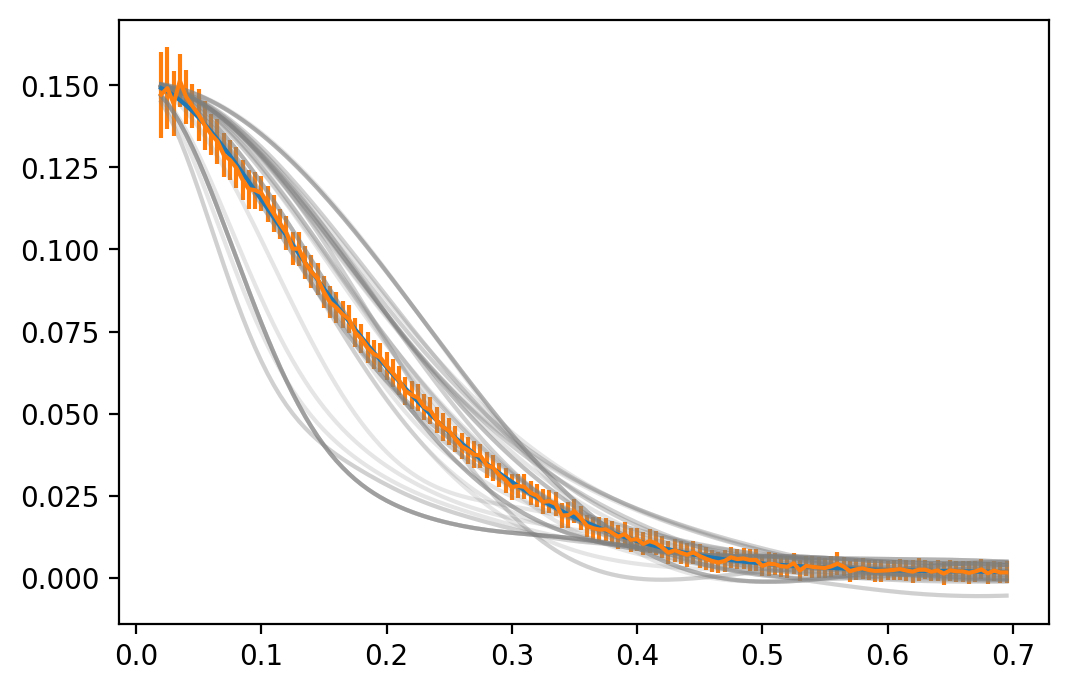

In [37]:
plt.figure(dpi=200)
bf = ga.get_best_fit()

plt.plot(mea.q, bf[1].T, color='tab:gray', alpha=0.2)
plt.plot(mea.q, bf[0])
plt.errorbar(F_st.q, F_st.S_exp, F_st.S_err)

print(ga.chromosome_pool[0].res.x)

In [123]:
# Multiple genetic algorithm runs

key_sel = list(XS_pool.keys())

F_GA_pool = [GeneticAlgorithm(XS_pool[x], F_st.S_exp, F_st.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]

def fit_pool(obj):
    GA, n = obj
    GA.evolve(n, silence=True)
    return GA

In [124]:
pool = mp.Pool(8)
F_GA_pool = pool.map(fit_pool, zip(F_GA_pool, [50]*len(F_GA_pool)))
pool.close()
pool.join()

Done with evolution for (0.98, 1.2), best fit: 0.47228954088993275
Progress for (0.98, 0.0): Round 40, best fit: 0.20575545230563388
Progress for (0.98, 3.6): Round 39, best fit: 1.0442566467137702
Progress for (0.99, 3.0): Round 40, best fit: 0.9038640560398379
Progress for (0.99, 1.8): Round 46, best fit: 0.6644662566260958
Done with evolution for (0.99, 0.6), best fit: 0.2768074401921584
Progress for (0.98, 2.4): Round 42, best fit: 0.8127542450675936
Progress for (1.00, 0.0): Round 36, best fit: 0.2049494019320002
Done with evolution for (0.99, 1.8), best fit: 0.6468294446806816
Done with evolution for (0.98, 2.4), best fit: 0.7839818880503022
Done with evolution for (0.98, 0.0), best fit: 0.20560375279473117
Done with evolution for (0.99, 3.0), best fit: 0.8818881900367023
Done with evolution for (0.98, 3.6), best fit: 1.016400328110393
Done with evolution for (1.00, 0.0), best fit: 0.20256665813709002
Done with evolution for (0.99, 0.8), best fit: 0.3264591449045237
Done with evo

Progress for (1.02, 0.2): Round 30, best fit: 0.20106553420956283
Done with evolution for (1.01, 2.2), best fit: 0.7157327392209004
Progress for (1.01, 1.0): Round 43, best fit: 0.3953279287904803
Done with evolution for (1.00, 4.0), best fit: 1.064465849116637
Progress for (1.00, 2.0): Round 40, best fit: 0.6926039725422339
Done with evolution for (1.01, 1.0), best fit: 0.37828203050058445
Progress for (1.00, 3.0): Round 35, best fit: 0.9554090267280476
Done with evolution for (1.02, 0.2), best fit: 0.20106553420956283
Done with evolution for (1.00, 2.0), best fit: 0.653478915178403
Done with evolution for (1.02, 1.6), best fit: 0.5528364767236293
Progress for (1.01, 3.4): Round 35, best fit: 1.0154222101867776
Done with evolution for (1.00, 3.0), best fit: 0.9033141656973063
Progress for (1.01, 2.4): Round 39, best fit: 0.7722717968990953
Done with evolution for (1.01, 3.4), best fit: 0.9564669811422781
Done with evolution for (1.01, 2.4), best fit: 0.749814565611008
Progress for (1.

Progress for (1.04, 3.6): Round 32, best fit: 1.0745458871110232
Done with evolution for (1.03, 3.8), best fit: 1.055271127481379
Done with evolution for (1.04, 3.0), best fit: 0.8461176671136019
Progress for (1.03, 1.4): Round 33, best fit: 0.5180815343270041
Progress for (1.04, 1.8): Round 33, best fit: 0.5235159060355057
Done with evolution for (1.04, 3.6), best fit: 1.0139094582172352
Progress for (1.04, 0.4): Round 44, best fit: 0.2031150860013604
Progress for (1.05, 0.6): Round 21, best fit: 0.22021926783023812
Done with evolution for (1.03, 1.4), best fit: 0.4330190979511022
Done with evolution for (1.04, 0.4), best fit: 0.20105007327996077
Done with evolution for (1.04, 1.8), best fit: 0.4670967388739597
Progress for (1.03, 0.2): Round 47, best fit: 0.20321583996846695
Done with evolution for (1.03, 0.2), best fit: 0.20321583996846695
Progress for (1.03, 4.0): Round 30, best fit: 1.1198928551956253
Progress for (1.04, 3.2): Round 35, best fit: 0.9618040903909385
Progress for (1

In [125]:
key_sel = list(XS_pool.keys())

U_GA_pool = [GeneticAlgorithm(XS_pool[x], U_st.S_exp, U_st.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [126]:
pool = mp.Pool(8)
U_GA_pool = pool.map(fit_pool, zip(U_GA_pool, [50]*len(U_GA_pool)))
pool.close()
pool.join()

Progress for (0.98, 2.4): Round 38, best fit: 0.396923267980151
Progress for (0.98, 3.6): Round 35, best fit: 0.39460490086547356
Progress for (0.98, 1.2): Round 36, best fit: 0.3990628936202475
Progress for (0.99, 0.6): Round 31, best fit: 0.4106986986603314
Progress for (0.99, 1.8): Round 39, best fit: 0.3923652188381584
Progress for (0.99, 3.0): Round 36, best fit: 0.3940194512332996
Progress for (0.98, 0.0): Round 30, best fit: 0.43132450308792025
Progress for (1.00, 0.0): Round 28, best fit: 0.4274723250845042
Done with evolution for (0.98, 2.4), best fit: 0.3924147412920924
Done with evolution for (0.99, 1.8), best fit: 0.3909317651804217
Done with evolution for (0.99, 3.0), best fit: 0.38772546519398804
Done with evolution for (0.98, 3.6), best fit: 0.38997438373038096
Done with evolution for (0.98, 1.2), best fit: 0.39556403949680835
Done with evolution for (0.99, 0.6), best fit: 0.3925166474539173
Done with evolution for (0.98, 0.0), best fit: 0.398211821037537
Done with evolu

Done with evolution for (1.00, 1.0), best fit: 0.392119401815892
Progress for (1.00, 3.8): Round 26, best fit: 0.3983570696394289
Progress for (1.02, 0.0): Round 19, best fit: 0.4726376244849639
Done with evolution for (1.00, 2.6), best fit: 0.3890693085696331
Done with evolution for (1.01, 1.8), best fit: 0.38647243784326746
Done with evolution for (1.01, 3.0), best fit: 0.39379512005726547
Done with evolution for (1.00, 1.4), best fit: 0.3874266720637257
Progress for (1.01, 0.8): Round 21, best fit: 0.4217858515854872
Done with evolution for (1.00, 3.8), best fit: 0.3894587565846545
Progress for (1.02, 1.2): Round 22, best fit: 0.40816978251581454
Progress for (1.02, 0.0): Round 38, best fit: 0.4017693619071303
Progress for (1.00, 2.8): Round 27, best fit: 0.39794799316201807
Progress for (1.01, 2.0): Round 25, best fit: 0.40247859236704214
Progress for (1.01, 3.2): Round 25, best fit: 0.40079385749098745
Progress for (1.00, 1.6): Round 24, best fit: 0.4102188014789305
Progress for (

Done with evolution for (1.02, 2.2), best fit: 0.3879426744148715
Progress for (1.03, 0.8): Round 19, best fit: 0.43194672619739455
Progress for (1.03, 2.0): Round 22, best fit: 0.4090232635283816
Done with evolution for (1.02, 2.8), best fit: 0.38259213408303855
Progress for (1.03, 3.2): Round 27, best fit: 0.3971802593313117
Done with evolution for (1.02, 4.0), best fit: 0.38458428539920386
Done with evolution for (1.04, 0.0), best fit: 0.3932575313056539
Progress for (1.02, 1.0): Round 42, best fit: 0.39109003835197437
Progress for (1.04, 1.2): Round 20, best fit: 0.4133512752244395
Progress for (1.03, 0.8): Round 39, best fit: 0.38931225775902234
Done with evolution for (1.03, 3.2), best fit: 0.3849987799877404
Progress for (1.03, 2.0): Round 45, best fit: 0.3948442307738119
Progress for (1.02, 3.0): Round 29, best fit: 0.3895488327385011
Done with evolution for (1.02, 1.0), best fit: 0.3873749556681667
Done with evolution for (1.03, 2.0), best fit: 0.39300334283130717
Done with ev

Done with evolution for (1.05, 2.0), best fit: 0.380285585088697
Done with evolution for (1.05, 0.0), best fit: 0.38314093933815985
Progress for (1.04, 1.0): Round 45, best fit: 0.3810524982311741
Done with evolution for (1.04, 2.2), best fit: 0.3831433794262415
Done with evolution for (1.04, 1.0), best fit: 0.3810524982311741
Progress for (1.05, 3.4): Round 33, best fit: 0.3879949807374721
Progress for (1.05, 2.2): Round 28, best fit: 0.3867339115295866
Progress for (1.05, 1.0): Round 25, best fit: 0.40828289535290146
Progress for (1.05, 0.2): Round 23, best fit: 0.4196564706363823
Done with evolution for (1.05, 3.4), best fit: 0.38160819821942177
Done with evolution for (1.05, 2.2), best fit: 0.37877432969387065
Done with evolution for (1.05, 1.0), best fit: 0.3821675075255117
Progress for (1.05, 0.2): Round 49, best fit: 0.3815387409668785
Done with evolution for (1.05, 0.2), best fit: 0.3815387409668785
Progress for (1.05, 3.6): Round 39, best fit: 0.39050027050249164
Done with evo

In [128]:
key_sel = list(XS_pool.keys())

Itr_GA_pool = [GeneticAlgorithm(XS_pool[x], I_tr.S_exp, I_tr.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [138]:
pool = mp.Pool(8)
Itr_GA_pool = pool.map(fit_pool, zip(Itr_GA_pool, [50]*len(Itr_GA_pool)))
pool.close()
pool.join()

Done with evolution for (0.99, 1.8), best fit: 1.1068055958970568
Progress for (0.98, 0.0): Round 88, best fit: 1.0440480068959257
Progress for (0.98, 2.4): Round 98, best fit: 1.140686051814892
Progress for (0.99, 0.6): Round 89, best fit: 1.052895188801947
Progress for (0.98, 1.2): Round 95, best fit: 1.0688609042929165
Progress for (0.98, 3.6): Round 94, best fit: 1.2139138471541646
Progress for (0.99, 3.0): Round 95, best fit: 1.1778053786697908
Progress for (1.00, 0.0): Round 83, best fit: 1.0546526605840199
Done with evolution for (0.98, 2.4), best fit: 1.139716081348891
Done with evolution for (0.98, 1.2), best fit: 1.0686615196239169
Done with evolution for (0.99, 3.0), best fit: 1.177452721822491
Done with evolution for (0.98, 3.6), best fit: 1.213884277567767
Done with evolution for (0.99, 0.6), best fit: 1.051096666261807
Done with evolution for (0.98, 0.0), best fit: 1.0432442487261926
Done with evolution for (1.00, 0.0), best fit: 1.0499497577645207
Done with evolution for

Done with evolution for (1.01, 0.8), best fit: 1.0390939913092667
Done with evolution for (1.01, 3.2), best fit: 1.1901659553606947
Progress for (1.02, 0.2): Round 75, best fit: 1.0459975352210429
Progress for (1.00, 4.0): Round 81, best fit: 1.2379350589118567
Progress for (1.00, 3.0): Round 82, best fit: 1.1887363463654477
Progress for (1.01, 2.2): Round 86, best fit: 1.1079579816706142
Progress for (1.02, 1.4): Round 79, best fit: 1.1054448690123244
Progress for (1.00, 1.8): Round 87, best fit: 1.1253773861590712
Done with evolution for (1.01, 2.2), best fit: 1.1055769810960203
Done with evolution for (1.00, 3.0), best fit: 1.1852648809421111
Done with evolution for (1.00, 4.0), best fit: 1.2334873420845558
Progress for (1.01, 1.0): Round 78, best fit: 1.0588434292306286
Done with evolution for (1.00, 1.8), best fit: 1.1226116758277227
Progress for (1.01, 3.4): Round 83, best fit: 1.192605391738512
Done with evolution for (1.02, 0.2), best fit: 1.0434630198461725
Done with evolution

Done with evolution for (1.03, 3.6), best fit: 1.219186088618038
Progress for (1.04, 0.4): Round 74, best fit: 1.0388731622760579
Progress for (1.03, 2.4): Round 81, best fit: 1.1389692671426719
Done with evolution for (1.03, 1.2), best fit: 1.0396014236184805
Progress for (1.03, 0.2): Round 98, best fit: 1.05345607605018
Done with evolution for (1.03, 0.2), best fit: 1.05345607605018
Progress for (1.04, 1.6): Round 77, best fit: 1.1044240470643503
Done with evolution for (1.03, 2.4), best fit: 1.1383103388501674
Progress for (1.04, 3.6): Round 88, best fit: 1.2411033041614912
Progress for (1.04, 2.8): Round 80, best fit: 1.1182722181677927
Progress for (1.03, 3.8): Round 82, best fit: 1.2622716219980146
Progress for (1.04, 0.4): Round 97, best fit: 1.0382021176537328
Done with evolution for (1.04, 3.6), best fit: 1.2363562273486413
Done with evolution for (1.04, 0.4), best fit: 1.037213684039686
Progress for (1.03, 1.4): Round 77, best fit: 1.0532264806846863
Done with evolution for (

In [134]:
key_sel = list(XS_pool.keys())

Utr_GA_pool = [GeneticAlgorithm(XS_pool[x], U_tr.S_exp, U_tr.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [135]:
pool = mp.Pool(8)
Utr_GA_pool = pool.map(fit_pool, zip(Utr_GA_pool, [50]*len(Utr_GA_pool)))
pool.close()
pool.join()

Done with evolution for (0.98, 3.6), best fit: 0.6102012089927715
Done with evolution for (0.99, 3.0), best fit: 0.600492620266944
Done with evolution for (0.98, 2.4), best fit: 0.5981745031134675
Progress for (0.98, 1.2): Round 46, best fit: 0.5946797077599896
Progress for (0.99, 0.6): Round 42, best fit: 0.5950155192973378
Progress for (0.98, 0.0): Round 40, best fit: 0.5925692309961507
Progress for (0.99, 1.8): Round 49, best fit: 0.5958784096173099
Progress for (1.00, 0.0): Round 40, best fit: 0.5937286687325175
Done with evolution for (0.99, 1.8), best fit: 0.5956910994334564
Done with evolution for (0.98, 1.2), best fit: 0.5946797077599896
Done with evolution for (0.99, 0.6), best fit: 0.5946997177265
Done with evolution for (0.98, 0.0), best fit: 0.5925568469223226
Done with evolution for (1.00, 0.0), best fit: 0.5934249953004217
Progress for (0.98, 3.8): Round 49, best fit: 0.6116072220173814
Done with evolution for (0.98, 3.8), best fit: 0.6116072220173814
Progress for (0.99, 

Done with evolution for (1.01, 3.0), best fit: 0.6004781169965593
Done with evolution for (1.00, 3.8), best fit: 0.6105128517625843
Progress for (1.02, 1.2): Round 21, best fit: 0.5948615253163938
Progress for (1.01, 2.0): Round 24, best fit: 0.5976336571203126
Progress for (1.01, 0.8): Round 21, best fit: 0.5961071743639549
Progress for (1.00, 2.8): Round 27, best fit: 0.6114106509259174
Progress for (1.00, 1.6): Round 24, best fit: 0.5960924212744463
Progress for (1.02, 0.0): Round 39, best fit: 0.5933132367363517
Progress for (1.01, 3.2): Round 29, best fit: 0.6106014845382784
Progress for (1.00, 4.0): Round 32, best fit: 0.6307125649442628
Progress for (1.02, 1.2): Round 44, best fit: 0.5939611350553864
Done with evolution for (1.00, 2.8), best fit: 0.6011721019925725
Done with evolution for (1.02, 0.0), best fit: 0.5933132367363517
Progress for (1.01, 2.0): Round 49, best fit: 0.5957795065151149
Progress for (1.01, 0.8): Round 44, best fit: 0.5941592027564103
Done with evolution f

Progress for (1.04, 1.2): Round 21, best fit: 0.5923371841135388
Done with evolution for (1.04, 0.0), best fit: 0.5922695752362883
Done with evolution for (1.02, 1.0), best fit: 0.5926784679614566
Done with evolution for (1.03, 0.8), best fit: 0.5928338332328994
Progress for (1.02, 3.0): Round 27, best fit: 0.60884803483497
Progress for (1.03, 3.4): Round 27, best fit: 0.6140460787919597
Progress for (1.03, 0.0): Round 18, best fit: 0.593557789714272
Progress for (1.03, 2.2): Round 24, best fit: 0.5982789221066295
Progress for (1.04, 1.2): Round 43, best fit: 0.5911561124140554
Done with evolution for (1.02, 3.0), best fit: 0.6000912230373778
Progress for (1.04, 0.2): Round 18, best fit: 0.594861987086594
Progress for (1.03, 1.0): Round 21, best fit: 0.5943729672163561
Progress for (1.04, 2.4): Round 24, best fit: 0.599820257316907
Done with evolution for (1.04, 1.2), best fit: 0.5911519509315685
Done with evolution for (1.03, 3.4), best fit: 0.6018404591294445
Progress for (1.03, 0.0)

Done with evolution for (1.05, 2.2), best fit: 0.5941181437264221
Progress for (1.05, 0.2): Round 25, best fit: 0.5947178327933597
Done with evolution for (1.05, 1.0), best fit: 0.5924623205700389
Progress for (1.05, 3.6): Round 42, best fit: 0.6007975640804563
Progress for (1.05, 2.4): Round 36, best fit: 0.5963376997869297
Done with evolution for (1.05, 3.6), best fit: 0.5982214780516104
Done with evolution for (1.05, 0.2), best fit: 0.5930940815545529
Progress for (1.05, 1.2): Round 33, best fit: 0.5929489850803904
Done with evolution for (1.05, 2.4), best fit: 0.5956641970504155
Done with evolution for (1.05, 1.2), best fit: 0.5921717634497677
Progress for (1.05, 3.8): Round 45, best fit: 0.6064692970121972
Progress for (1.05, 0.4): Round 30, best fit: 0.593891742881681
Done with evolution for (1.05, 3.8), best fit: 0.6049225274031963
Progress for (1.05, 2.6): Round 37, best fit: 0.5963278281587677
Progress for (1.05, 1.4): Round 33, best fit: 0.5933794693303922
Done with evolution

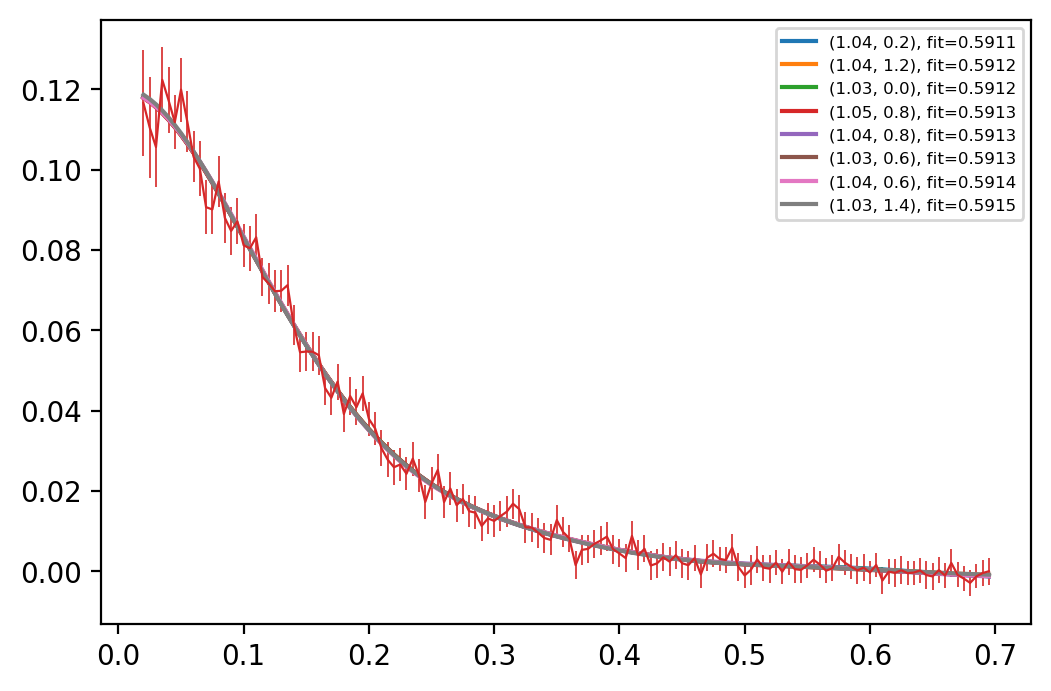

In [146]:
plt.figure(dpi=200)

# Change these to plot for different states
data = U_tr
mpools = Utr_GA_pool

plt.errorbar(data.q, data.S_exp, data.S_err, color='tab:red', linewidth = 0.8, elinewidth=0.6)
fitness_pile = [ga.best_fitness for ga in mpools]
fitness_rank = np.argsort(fitness_pile)
for ga_rank in fitness_rank[:8]:
    ga = mpools[ga_rank]
    bf = ga.get_best_fit()
    bl = ga.label + f', fit={ga.best_fitness:.4f}'

# plt.plot(mea.q, bf[1].T, color='tab:gray', alpha=0.2)
    plt.plot(mea.q, bf[0], label=bl)
    
# plt.yscale('log')
plt.legend(loc='best', fontsize=6)

# print(ga.chromosome_pool[0].res.x)